## Import Libs

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Importing Deep Learning Libraries

from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense,Input,Dropout,GlobalAveragePooling2D,Flatten,Conv2D,BatchNormalization,Activation,MaxPooling2D
from keras.models import Model,Sequential
from keras.optimizers import Adam,SGD,RMSprop

Using TensorFlow backend.


In [3]:
import sagemaker
import boto3, os
import io
import sys

sess = sagemaker.Session()
role = sagemaker.get_execution_role()

picture_size = 48
folder_path = "./dataset/"

s3_bucket = "restauai"

print(role)
boto3.client('s3').list_buckets()

arn:aws:iam::321977351608:role/service-role/AmazonSageMakerServiceCatalogProductsUseRole


{'ResponseMetadata': {'RequestId': 'RQV5QEWHF84PX0B4',
  'HostId': 'NsAO19i0HO+iIwEZ9E2OYyxhSHaAvlyE2axz6CRIhKuKj2wEWHnli8PCRGW8a/ceGz5f5ACt3ac=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'NsAO19i0HO+iIwEZ9E2OYyxhSHaAvlyE2axz6CRIhKuKj2wEWHnli8PCRGW8a/ceGz5f5ACt3ac=',
   'x-amz-request-id': 'RQV5QEWHF84PX0B4',
   'date': 'Tue, 08 Mar 2022 00:46:33 GMT',
   'content-type': 'application/xml',
   'transfer-encoding': 'chunked',
   'server': 'AmazonS3'},
  'RetryAttempts': 0},
 'Buckets': [{'Name': 'airflow-sagemaker-545e92f0',
   'CreationDate': datetime.datetime(2022, 2, 26, 11, 43, 42, tzinfo=tzlocal())},
  {'Name': 'restauai',
   'CreationDate': datetime.datetime(2022, 2, 24, 17, 13, 28, tzinfo=tzlocal())},
  {'Name': 'sagemaker-ap-southeast-1-321977351608',
   'CreationDate': datetime.datetime(2021, 9, 12, 12, 5, 7, tzinfo=tzlocal())},
  {'Name': 'sagemaker-studio-a8ln4n0zri',
   'CreationDate': datetime.datetime(2021, 9, 12, 4, 43, tzinfo=tzlocal())},
  {'Name': 'sagem

# Data Preparation

## Analyze the dataset


In [3]:
dataset_path = 'dataset.zip'
boto3.client('s3').download_file(s3_bucket, dataset_path, 'dataset.zip')

In [4]:
rm -rf dataset

In [5]:
!unzip dataset.zip

Archive:  dataset.zip
   creating: dataset/
  inflating: dataset/.DS_Store       
  inflating: __MACOSX/dataset/._.DS_Store  
   creating: dataset/train/
  inflating: __MACOSX/dataset/._train  
   creating: dataset/.git/
   creating: dataset/validation/
  inflating: __MACOSX/dataset/._validation  
   creating: dataset/train/happy/
  inflating: __MACOSX/dataset/train/._happy  
   creating: dataset/train/sad/
  inflating: __MACOSX/dataset/train/._sad  
   creating: dataset/train/fear/
  inflating: __MACOSX/dataset/train/._fear  
   creating: dataset/train/surprise/
  inflating: __MACOSX/dataset/train/._surprise  
   creating: dataset/train/neutral/
  inflating: __MACOSX/dataset/train/._neutral  
   creating: dataset/train/angry/
  inflating: __MACOSX/dataset/train/._angry  
   creating: dataset/train/disgust/
  inflating: __MACOSX/dataset/train/._disgust  
  inflating: dataset/.git/config     
   creating: dataset/.git/objects/
  inflating: dataset/.git/HEAD       
   creating: dataset/.

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)




  inflating: dataset/.git/objects/pack/pack-fcd15497d53dbb425a0a0821004cd97d66139fae.idx  
  inflating: dataset/.git/objects/info/commit-graph  
  inflating: dataset/.git/objects/info/packs  
   creating: dataset/.git/logs/refs/heads/
   creating: dataset/.git/logs/refs/remotes/
   creating: dataset/.git/refs/remotes/origin/
  inflating: dataset/.git/logs/refs/heads/master  
   creating: dataset/.git/logs/refs/remotes/origin/
  inflating: dataset/.git/refs/remotes/origin/master  
  inflating: dataset/.git/logs/refs/remotes/origin/master  


In [6]:
!ls -al

total 121124
drwxr-xr-x  7 ec2-user ec2-user      4096 Mar  5 12:15 .
drwx------ 22 ec2-user ec2-user      4096 Mar  5 10:59 ..
drwxr-xr-x  5 ec2-user ec2-user      4096 Sep 19 06:21 dataset
-rw-rw-r--  1 ec2-user ec2-user 123868085 Mar  5 12:14 dataset.zip
-rw-rw-r--  1 ec2-user ec2-user    104742 Dec 19 18:12 emotion-model-using-keras.ipynb
drwxrwxr-x  2 ec2-user ec2-user      4096 Feb  7 04:39 .ipynb_checkpoints
drwx------  2 root     root         16384 Sep 12 11:52 lost+found
drwxrwxr-x  3 ec2-user ec2-user      4096 Mar  5 12:15 __MACOSX
-rw-rw-r--  1 ec2-user ec2-user      8932 Mar  5 12:15 restauai-conda-amazonei-tensor2-make-data.ipynb
drwxr-xr-x  2 ec2-user ec2-user      4096 Sep 12 11:52 .sparkmagic


## Displaying Images

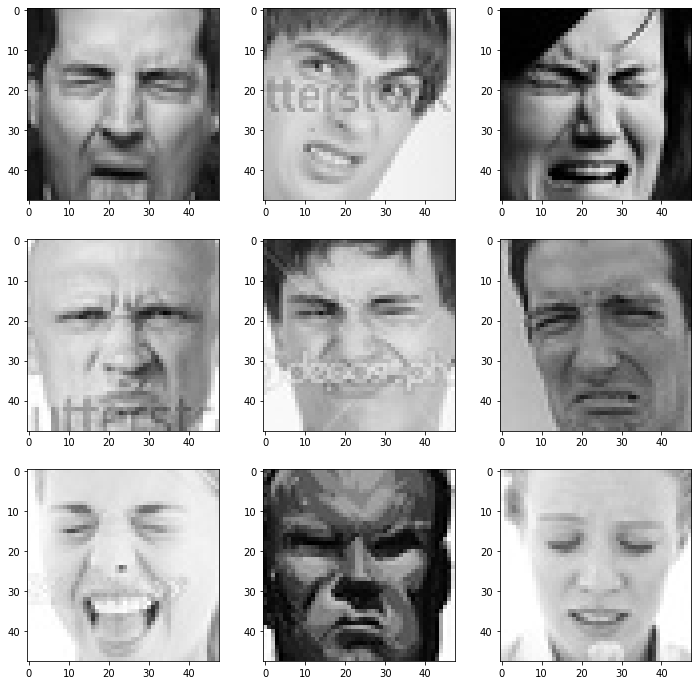

In [7]:
expression = 'disgust'

plt.figure(figsize= (12,12))
for i in range(1, 10, 1):
    plt.subplot(3,3,i)
    img = load_img(folder_path+"train/"+expression+"/"+
                  os.listdir(folder_path + "train/" + expression)[i], target_size=(picture_size, picture_size))
    plt.imshow(img)   
plt.show()

# Model

## Train with Tensorflow on a GPU instance

In [6]:
from sagemaker.tensorflow import TensorFlow

# GPU instance
tf_estimator = TensorFlow(entry_point='4_layers_keras_tf.py', 
                          role=role,
                          instance_count=1, 
                          instance_type='ml.m5.4xlarge',
#                           framework_version='2.1.3',
                          framework_version='1.12',
                          py_version='py3',
                          script_mode=True,
                          hyperparameters={
                              'epochs': 20,
                              'batch-size': 512,
                              'learning-rate': 0.01}
                         )

# Local instance
# tf_estimator = TensorFlow(entry_point='4_layers_keras_tf.py', 
#                           role=role,
#                           instance_count=1, 
#                           instance_type='local',
#                           framework_version='2.1.3', 
#                           py_version='py3',
#                           script_mode=True,
#                           hyperparameters={
#                               'epochs': 20,
#                               'batch-size': batch_size,
#                               'learning-rate': 0.01}
#                           )

In [63]:
import tensorflow as tf
print(tf.__version__)

2.1.3


In [64]:
tf_estimator.fit() 

2022-03-06 07:40:51 Starting - Starting the training job...
2022-03-06 07:41:14 Starting - Preparing the instances for trainingProfilerReport-1646552451: InProgress
......
2022-03-06 07:42:20 Downloading - Downloading input data
2022-03-06 07:42:20 Training - Downloading the training image......
2022-03-06 07:43:15 Training - Training image download completed. Training in progress.2022-03-06 07:43:13,002 sagemaker-containers INFO     Imported framework sagemaker_tensorflow_container.training
2022-03-06 07:43:13,008 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2022-03-06 07:43:13,344 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2022-03-06 07:43:13,359 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2022-03-06 07:43:13,369 sagemaker-containers INFO     Invoking user script
Training Env:
{
    "additional_framework_parameters": {},
    "channel_input_dirs": {},
    "current_host": "algo-1",
    "f

In [36]:
tf_estimator.fit() 

2022-03-05 17:16:23 Starting - Starting the training job...
2022-03-05 17:16:46 Starting - Preparing the instances for trainingProfilerReport-1646500583: InProgress
......
2022-03-05 17:17:48 Downloading - Downloading input data
2022-03-05 17:17:48 Training - Downloading the training image..2022-03-05 17:18:02,600 sagemaker-containers INFO     Imported framework sagemaker_tensorflow_container.training
2022-03-05 17:18:02,607 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2022-03-05 17:18:02,931 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2022-03-05 17:18:02,946 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2022-03-05 17:18:02,956 sagemaker-containers INFO     Invoking user script
Training Env:
{
    "additional_framework_parameters": {},
    "channel_input_dirs": {},
    "current_host": "algo-1",
    "framework_module": "sagemaker_tensorflow_container.training:main",
    "hosts": [
        "al

# Model Tuning

In [7]:
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner

tf_estimator = TensorFlow(entry_point='4_layers_keras_tf.py', 
                          role=role,
                          instance_count=1, 
                          instance_type='ml.m4.xlarge',
                          framework_version='1.12',
                          py_version='py3',
                          script_mode=True,
                         )

hyperparameter_ranges = {
    'epochs':        IntegerParameter(10, 100),
    'learning-rate': ContinuousParameter(0.001, 0.1, scaling_type='Logarithmic'), 
    'batch-size':    IntegerParameter(32, 1024),
#     'dense-layer':   IntegerParameter(128, 1024),
    'dropout':       ContinuousParameter(0.2, 0.6)
}

objective_metric_name = 'val_acc'
objective_type = 'Maximize'
metric_definitions = [{'Name': 'val_acc', 'Regex': 'val_acc: ([0-9\\.]+)'}]

tuner = HyperparameterTuner(tf_estimator,
                            objective_metric_name,
                            hyperparameter_ranges,
                            metric_definitions,
                            max_jobs=12,
                            max_parallel_jobs=4,
                            objective_type=objective_type)

In [ ]:
tuner.fit()

..........

## Deploy

In [43]:
import time

tf_endpoint_name = 'keras-tf-restauai-'+time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())


tf_predictor = tf_estimator.deploy(initial_instance_count=1,
                         instance_type='ml.m4.xlarge',
                         endpoint_name=tf_endpoint_name)

update_endpoint is a no-op in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


----!

### Deploying directly from model artifacts

In [53]:
from sagemaker.tensorflow import TensorFlowModel

model = TensorFlowModel(
    model_data='s3://sagemaker-ap-southeast-1-321977351608/sagemaker-tensorflow-scriptmode-2022-03-05-17-16-22-538/output/model.tar.gz',
    role=role,
    framework_version='1.12'
)

tf_predictor = model.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')
tf_endpoint_name = tf_predictor.endpoint_name

update_endpoint is a no-op in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


----!

## Prediction

In [ ]:
from numpy import asarray

target_img = load_img(folder_path+"train/"+expression+"/"+
                  os.listdir(folder_path + "train/" + expression)[12], target_size=(picture_size, picture_size))
target_img = asarray(target_img)
roi = target_img[np.newaxis, :, :, np.newaxis]

print(target_img)
sys.exit()

prediction = tf_predictor.predict(target_img)['predictions']
prediction = np.array(prediction)
predicted_label = prediction.argmax(axis=1)
print('Predicted labels are: {}'.format(predicted_label))

## Cleanup

In [57]:
sess.delete_endpoint(endpoint_name=tf_endpoint_name)